In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import os

from tabulate import tabulate

DIR = "../data/"
CONT_COL = "CONT"

In [2]:
df = pd.read_csv('../data/distribution/merged_filtered.csv')
df = df[df[CONT_COL] > 0]

# ---- we should consider which territories to keep in -------------------
# remove territories
to_remove = ['AS', 'FO', 'FM', 'GU', 'MH', 'MP', 'PR', 'VI']
df = df[(df['STATE'].isna() == False)]
for st in to_remove:
    df = df[df['STATE'] != st]
# ------------------------------------------------------------------------

count    4.288920e+05
mean     1.942802e+06
std      2.591008e+07
min      1.000000e+00
25%      3.061700e+04
50%      1.312380e+05
75%      6.395598e+05
max      9.265120e+09
Name: CONT, dtype: float64


<AxesSubplot:ylabel='Density'>

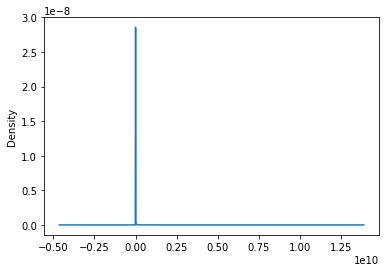

In [3]:
print(df[CONT_COL].describe())
df[CONT_COL].plot(kind='kde')

In [4]:
# remove outliers
q1 = df[CONT_COL].quantile(0.25)
q3 = df[CONT_COL].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
df = df[(df[CONT_COL] < high)]

count    3.660280e+05
mean     2.375189e+05
std      3.338691e+05
min      1.000000e+00
25%      2.366075e+04
50%      8.763100e+04
75%      3.035370e+05
max      1.552829e+06
Name: CONT, dtype: float64


<AxesSubplot:ylabel='Density'>

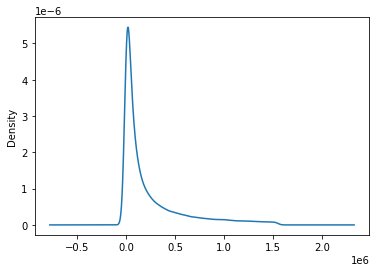

In [5]:
print(df[CONT_COL].describe())
df[CONT_COL].plot(kind='kde')

Adjusting for inflation... would love for someone to check my work here to make sure I'm doing this right.

In [6]:
# adjusting for inflation in terms of 2019
path = os.path.join(DIR, 'distribution', 'cpi_all.csv')
cpi = pd.read_csv(path)

# 990 forms filed may annually
cpi = cpi[['Year', 'May']]
years = cpi['Year'].tolist()

infl_adj = df[df['FISYR'] == max(df['FISYR'].tolist())].copy()
pct_rate = 0
for i in range(len(years) - 2, -1, -1):
    pct_rate += cpi.loc[i, 'May'] / 100
    temp = df[df['FISYR'] == years[i]].copy()
    temp[CONT_COL] = temp[CONT_COL].apply(lambda x: x * (pct_rate + 1))
    temp['SOLICIT'] = temp['SOLICIT'].apply(lambda x: x * (pct_rate + 1))
    infl_adj = pd.concat([infl_adj, temp])

In [7]:
total_conts = df[['FISYR', CONT_COL]].groupby('FISYR').sum().reset_index()
total_conts_adj = infl_adj[['FISYR', CONT_COL]].groupby('FISYR').sum().reset_index()

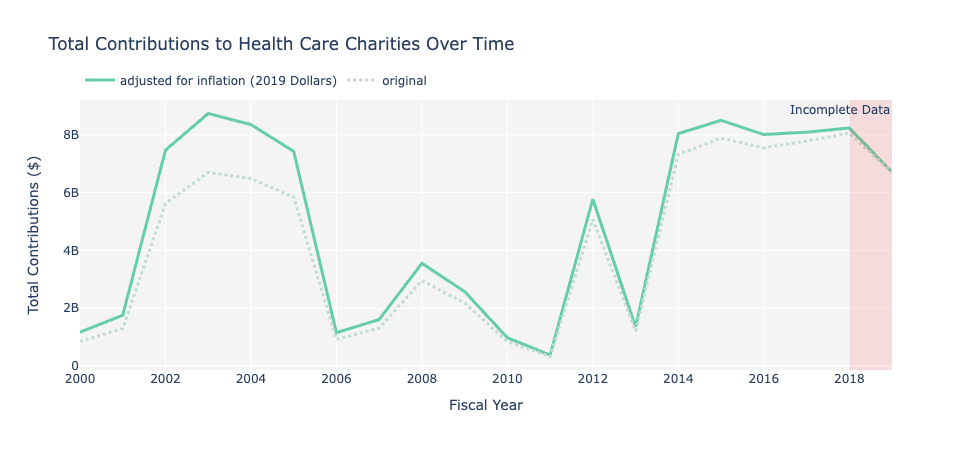

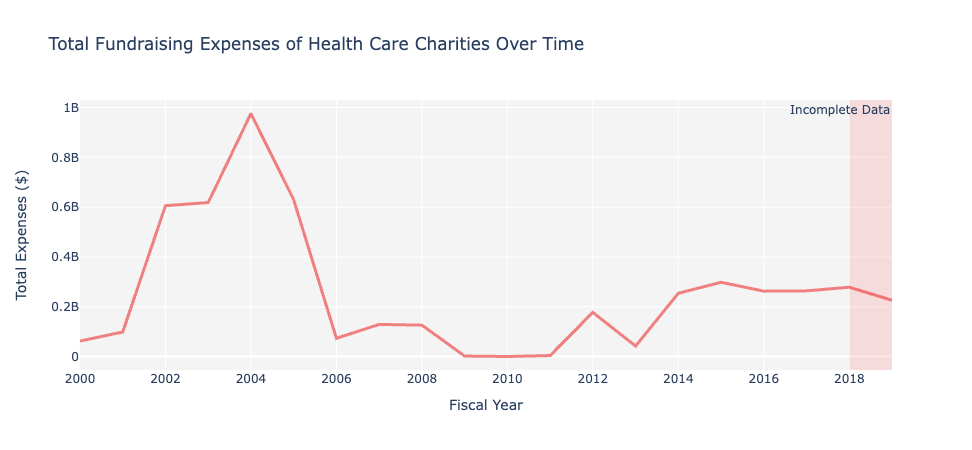

In [27]:
# contributions plot
fig = go.Figure()

line1 = go.Scatter(x=total_conts_adj['FISYR'], y=total_conts_adj[CONT_COL], name='adjusted for inflation ('
                   + str(int(max(total_conts['FISYR'].tolist()))) + ' Dollars)', yaxis='y1',
                   line = dict(color = ('mediumaquamarine'), width = 3))
line2 = go.Scatter(x=total_conts['FISYR'], y=total_conts[CONT_COL], name='original', yaxis='y1',
                   line = dict(color = ('rgba(193, 220, 207, 1)'), width = 3, dash='dot'))

fig.add_trace(line1)
fig.add_trace(line2)

fig.add_vrect(x0=max(total_conts['FISYR'].tolist()) - 1, x1=max(total_conts['FISYR'].tolist()), 
              annotation= dict(text="Incomplete Data"),
              fillcolor="red", opacity=0.1, line_width=0, name="incomplete data")

fig.update_layout(
    title='Total Contributions to Health Care Charities Over Time',
    xaxis_title='Fiscal Year',
    yaxis_title='Total Contributions ($)',
    plot_bgcolor='rgba(200, 200, 200, 0.2)',
    legend=dict(
        orientation="h",
        entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0)
    ) 
fig.show()

# expenses plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=fund_exp['FISYR'], y=fund_exp['SOLICIT'], name='fundraising expenses',
                   line = dict(color = ('lightcoral'), width = 3)))

fig.add_vrect(x0=max(total_conts['FISYR'].tolist()) - 1, x1=max(total_conts['FISYR'].tolist()), 
              annotation= dict(text="Incomplete Data"),
              fillcolor="red", opacity=0.1, line_width=0, name="incomplete data")

fig.update_layout(
    title='Total Fundraising Expenses of Health Care Charities Over Time',
    xaxis_title='Fiscal Year',
    yaxis_title='Total Expenses ($)',
    plot_bgcolor='rgba(200, 200, 200, 0.2)',
    legend=dict(
        orientation="h",
        entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0)
    ) 
fig.show()

In [9]:
fund_exp = df[['FISYR', 'SOLICIT']].groupby('FISYR').sum().reset_index()

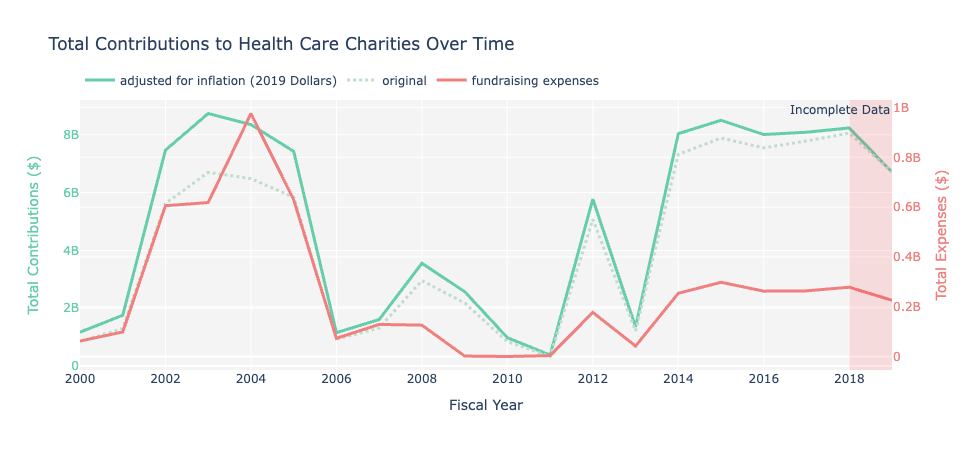

In [21]:
fig = go.Figure()

line1 = go.Scatter(x=total_conts_adj['FISYR'], y=total_conts_adj[CONT_COL], name='adjusted for inflation ('
                   + str(int(max(total_conts['FISYR'].tolist()))) + ' Dollars)', yaxis='y1',
                   line = dict(color = ('mediumaquamarine'), width = 3))
line2 = go.Scatter(x=total_conts['FISYR'], y=total_conts[CONT_COL], name='original', yaxis='y1',
                   line = dict(color = ('rgba(193, 220, 207, 1)'), width = 3, dash='dot'))
line3 = go.Scatter(x=fund_exp['FISYR'], y=fund_exp['SOLICIT'], name='fundraising expenses', yaxis='y2',
                   line = dict(color = ('lightcoral'), width = 3))

fig.add_trace(line1)
fig.add_trace(line2)
fig.add_trace(line3)
fig.add_vrect(x0=max(total_conts['FISYR'].tolist()) - 1, x1=max(total_conts['FISYR'].tolist()), 
              annotation= dict(text="Incomplete Data"),
              fillcolor="red", opacity=0.1, line_width=0, name="incomplete data")

fig.update_layout(
    title='Total Contributions to Health Care Charities Over Time',
    xaxis_title='Fiscal Year',
    yaxis_title='Total Contributions',
    plot_bgcolor='rgba(200, 200, 200, 0.2)',
    legend=dict(
        orientation="h",
        entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0),
    yaxis=dict(
        title="Total Contributions ($)",
        titlefont=dict(color="mediumaquamarine"),
        tickfont=dict(color="mediumaquamarine")),
    yaxis2=dict(
        title="Total Expenses ($)",
        overlaying="y",
        side="right",
        titlefont=dict(color="lightcoral"),
        tickfont=dict(color="lightcoral"))
    ) 
fig.show()